In [53]:
!pip install pandas numpy
!pip install yfinance
!pip install statsmodels arch  # For ARMA and GARCH models


ERROR: Invalid requirement: '#'


In [54]:
!pip install statsmodels

In [55]:
!pip install arch

In [56]:
!pip install pmdarima

In [57]:
import yfinance as yf
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import kurtosis
from statsmodels.graphics.gofplots import qqplot
from sklearn.model_selection import train_test_split
import pmdarima as pm
from scipy.stats import probplot
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import itertools
import os
from tensorflow.keras.callbacks import EarlyStopping

## Data Loading

In [58]:
# Fetch historical stock data
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data


In [59]:
stock_data = fetch_stock_data('AAPL', '2013-01-01', '2023-01-01')

[*********************100%%**********************]  1 of 1 completed


## Data Analysis and Preprocessing

### Data Analysis

In [60]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,19.779285,19.821428,19.343929,19.608213,16.769094,560518000
2013-01-03,19.567142,19.631071,19.321428,19.360714,16.557428,352965200
2013-01-04,19.177500,19.236786,18.779642,18.821428,16.096226,594333600
2013-01-07,18.642857,18.903570,18.400000,18.710714,16.001543,484156400
2013-01-08,18.900356,18.996071,18.616072,18.761070,16.044609,458707200
...,...,...,...,...,...,...
2022-12-23,130.919998,132.419998,129.639999,131.860001,131.127060,63814900
2022-12-27,131.380005,131.410004,128.720001,130.029999,129.307236,69007800
2022-12-28,129.669998,131.029999,125.870003,126.040001,125.339417,85438400


In [61]:
# Function to plot adjusted close values
def plot_adjusted_close(stock_data, ticker):
    stock_data['Adj Close'].plot(title=f'{ticker} Stock Adjusted Close Values Over Time')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.show()


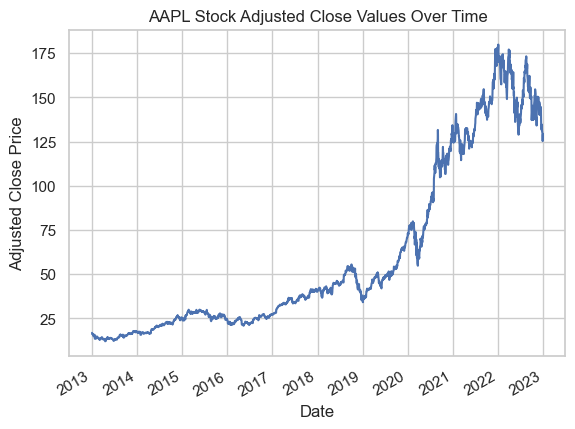

In [62]:
ticker = 'AAPL'
plot_adjusted_close(stock_data, ticker)

This visualization will help us understand the trend and fluctuations in the stock's price over the selected period. 

The provided Apple stock prices has multiple attributes, they are open, high, low, close and adjusted prices. For the analysis of the stock prices, the adjusted close stock values are selected as it gives a better idea of the overall value of the stock. Analysing the time plot of the data, we can see that the data is not stationary. The stock goes up and down but considering the whole data, we can see an upward trend factor. The variance of the model is also not constant. The stock data shows higher variability with higher stock value. From the time plot , it can be observed that the stocks are volatile. The stock data has volatility clustering, i.e., the conditional variance of the stock data varies over time.

### Make Data Stationary and Analyse Properties

From the data analysis It was observed that the data has a trend component and a changing variance. Taking the logarithm of the data can make the variance constant. The trend component can be removed by taking the difference of the data. It is multiplied by a value of 100 so that they can be interpreted as percentage changes in the stock.

To address the trend component and changing variance in our stock data, we can apply logarithmic transformation and differencing. This approach is commonly used in time series analysis to stabilize the variance and to make the series stationary. 

In [63]:
# Function to transform and analyze data
def transform_and_analyze(stock_data):
    # Taking the logarithm of the 'Adjusted Close' values
    log_data = np.log(stock_data['Adj Close'])

    # Differencing the log data to remove trend component
    diff_data = log_data.diff().dropna() * 100  # Multiplied by 100 for percentage change

    # Plotting the transformed data
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 1, 1)
    plt.plot(log_data, label='Log of Adjusted Close')
    plt.title('Logarithm of Adjusted Close Values')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(diff_data, label='Differenced Log Data')
    plt.title('Differenced Logarithmic Data (Percentage Change)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return diff_data, log_data

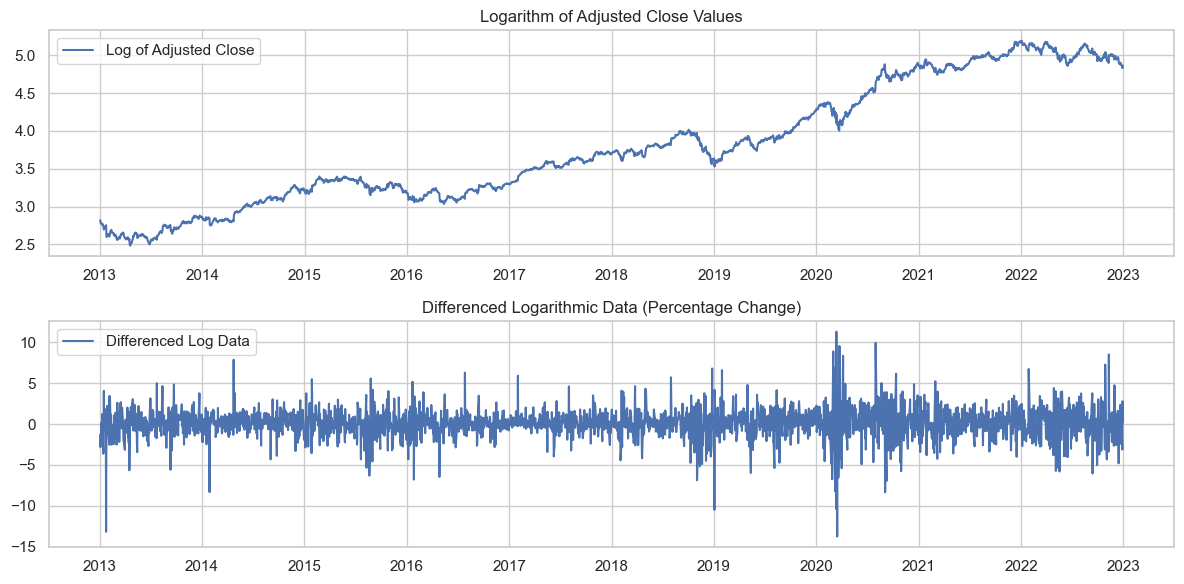

In [64]:
transformed_data, log_data = transform_and_analyze(stock_data)

* Logarithmic Transformation: np.log(stock_data['Adj Close']) computes the natural logarithm of the adjusted close values, which helps in stabilizing the variance.
* Differencing: log_data.diff().dropna() computes the difference between consecutive log values, which helps in removing the trend component.
* Multiplying by 100: This step converts the differenced log values into percentage changes.

we can see that the data has become stationary with constant mean. This can be confirmed by analysing the ACF and PACF of the obtained data.

Analyzing the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) is a key step in time series analysis, especially for confirming the stationarity of data. These functions help to identify the order of an ARIMA model for the time series. 

In [65]:
# Function to plot ACF and PACF
def plot_acf_pacf(data):
    plt.figure(figsize=(12, 6))

    # ACF plot
    plt.subplot(1, 2, 1)
    plot_acf(data, ax=plt.gca(), lags=30)

    # PACF plot
    plt.subplot(1, 2, 2)
    plot_pacf(data, ax=plt.gca(), lags=30)

    plt.tight_layout()
    plt.show()

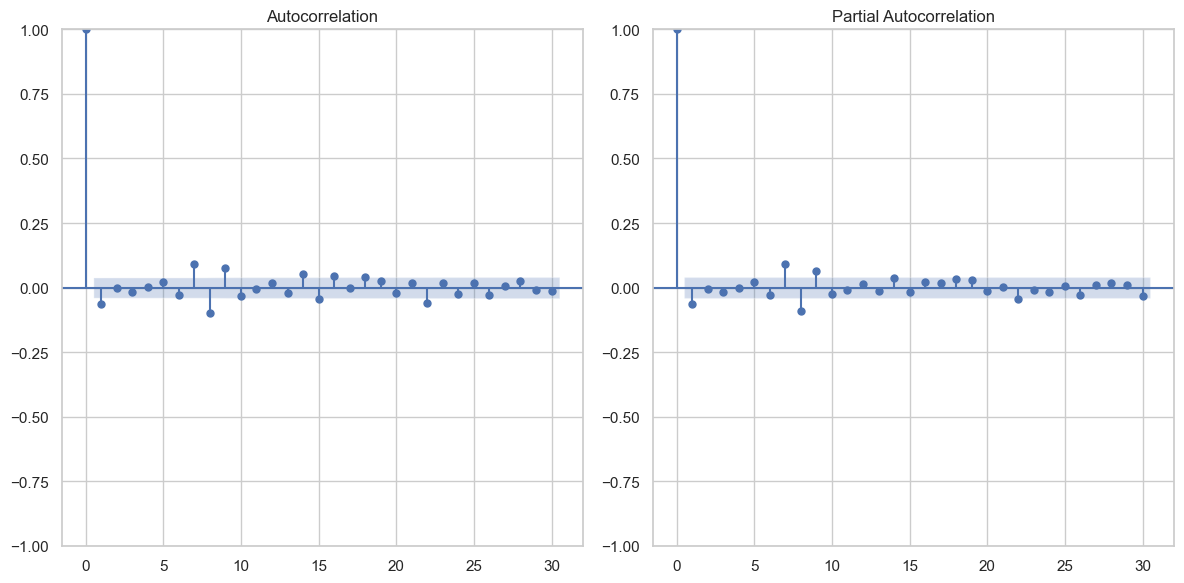

In [66]:
plot_acf_pacf(transformed_data)

we can observe that the ACF and PACF cut off and reduces rapidly concluding that the data is stationary. From the ACF and PACF plot, it can be understood that the data has very little serial correlation. But in the data analysis part, it was observed that the data has volatility clustering. So along with correlation, need to check whether the data is serially independent. For this, the absolute or squared value of the obtained stationary data is checked.

These plots will help identify the autocorrelation in the absolute values of the transformed data, which can be useful for identifying the nature of the volatility in the time series.
This approach is particularly useful when you're interested in understanding the volatility or the magnitude of changes in the time series, regardless of their direction (increase or decrease). 

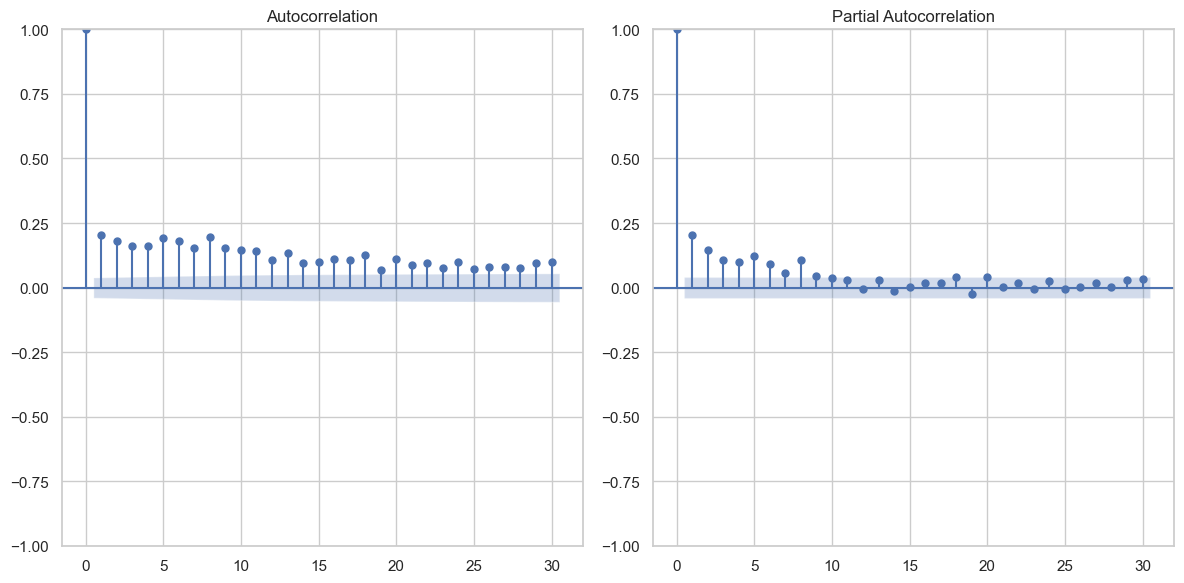

In [67]:
# Absolute value of transformed data
abs_data = np.abs(transformed_data)  

plot_acf_pacf(abs_data)

These plots are useful for identifying patterns in the variability (or volatility) of the time series. Squaring the data emphasizes larger changes more than smaller ones, which can be particularly insightful in financial time series analysis where you might be more interested in periods of high volatility.
This approach is valuable when analyzing the nature of volatility in financial time series data, as it accentuates the periods of larger changes in the stock prices. 

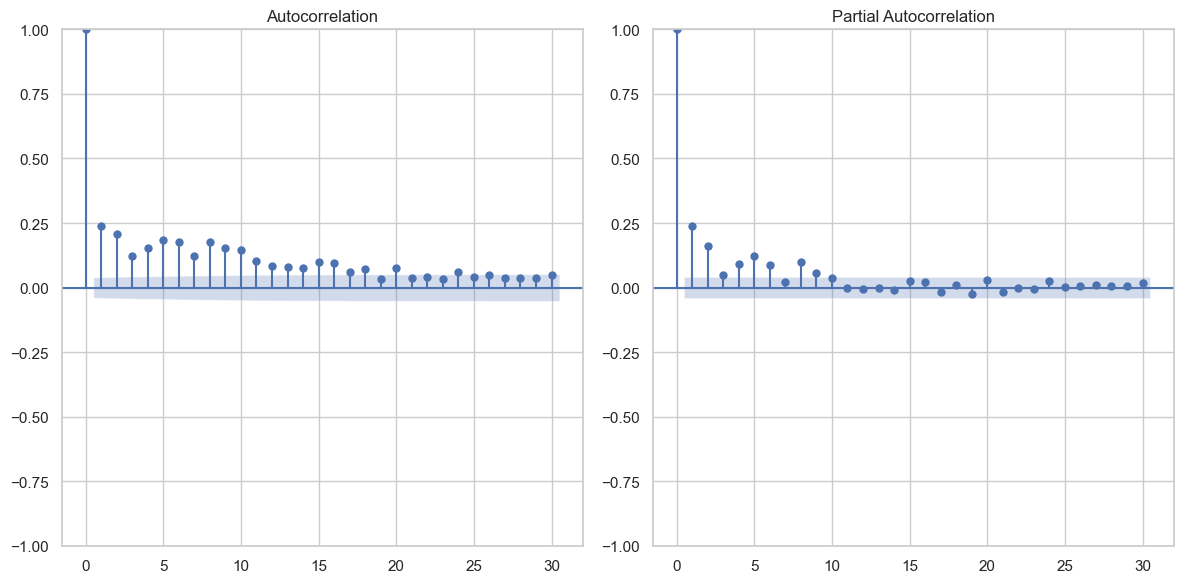

In [68]:
# Squaring the transformed data
squared_data = np.square(transformed_data)  

plot_acf_pacf(squared_data)

Analysing ACF and PACF of absolute and squared values in Figure 4 and 5, it can be observed that there is a significant autocorrelation. This is an evidence that the stock data is not independently and identically distributed. A Q-Q plot can be used to analyse how the data is distributed.

To analyze the distribution of your stock data, you can use a Q-Q (quantile-quantile) plot and calculate the excess kurtosis. The Q-Q plot compares the distribution of your data with a normal distribution, and the kurtosis value gives an indication of the 'tailedness' of the distribution. 

In [69]:
# Function to plot Q-Q plot and calculate kurtosis
def analyze_distribution(data):
    # Q-Q plot
    qqplot(data, line='s')
    plt.title('Q-Q Plot')
    plt.show()

    # Calculate and print kurtosis
    kurtosis_value = kurtosis(data, fisher=True)  # Excess kurtosis (Fisher's definition)
    print(f"Excess Kurtosis: {kurtosis_value}")

    # Interpretation of kurtosis
    if kurtosis_value > 0:
        print("Positive excess kurtosis indicates a heavy-tailed distribution.")
    else:
        print("Negative excess kurtosis indicates a light-tailed distribution.")


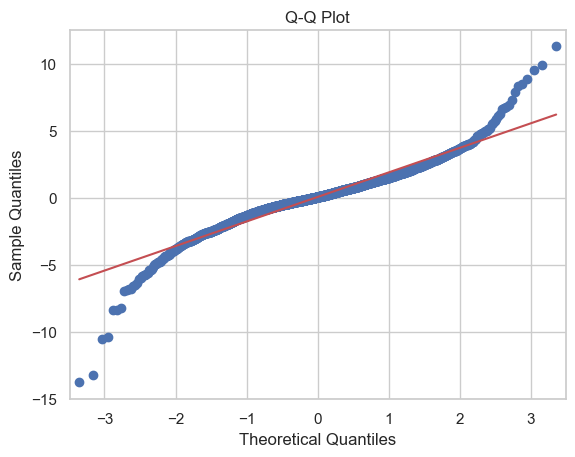

Excess Kurtosis: 6.082386945543934
Positive excess kurtosis indicates a heavy-tailed distribution.


In [70]:
analyze_distribution(transformed_data)

From Q-Q plot, it can be observed that the data deviates from the normal distribution and is a heavy tailed distribution. It can be confirmed by measuring the (excess) kurtosis by checking if the value is positive or negative. If positive, it is a heavy tailed distribution otherwise light tailed. 

## Fitting both ARMA and GARCH models 

The ARMA model will help capture the linear autocorrelation in the data, while the GARCH model is useful for modeling the changing volatility (conditional heteroskedasticity) often observed in financial time series.

In [71]:
# Function to fit Auto ARMA and calculate residuals
def fit_auto_arma(data):
    model = pm.auto_arima(data, start_p=1, start_q=1, test='adf', max_p=3, max_q=3,
                          m=1, d=None, seasonal=False, stepwise=True, suppress_warnings=True)
    return model, model.resid()

# Function to fit Auto GARCH
def fit_auto_garch(residuals):
    model = arch_model(residuals, vol='Garch', p=1, q=1).fit(disp='off')
    return model

In [72]:
# Fit Auto ARMA and calculate residuals
auto_arma_model, residuals = fit_auto_arma(transformed_data)

# Fit Auto GARCH
auto_garch_model = fit_auto_garch(residuals)

### Model Evaluation

In [73]:
# Function to evaluate ARMA and GARCH models
def evaluate_models(arma_model, garch_model):
    print("ARMA Model Summary:\n", arma_model.summary())
    print("\nGARCH Model Summary:\n", garch_model.summary())


In [74]:
evaluate_models(auto_arma_model, auto_garch_model)

ARMA Model Summary:
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2517
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -5092.309
Date:                Fri, 24 Nov 2023   AIC                          10190.619
Time:                        21:44:29   BIC                          10208.111
Sample:                             0   HQIC                         10196.967
                               - 2517                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0811      0.035      2.325      0.020       0.013       0.150
ma.L1         -0.0623      0.013     -4.736      0.000      -0.088      -0.036
sigma2         3.3483      0.05

C:\Users\thami\deeplearning\lib\site-packages\arch\univariate\base.py:1890: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if isinstance(table_val[pos], (np.float64, float)):
C:\Users\thami\deeplearning\lib\site-packages\arch\univariate\base.py:1891: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  assert isinstance(table_val[pos], float)
C:\Users\thami\deeplearning\lib\site-packages\arch\univariate\base.py:1892: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position,

In [75]:
# Function to plot further diagnostics for ARMA and GARCH models
def plot_diagnostics(auto_arma_model, residuals, garch_standardized_residuals):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 12))

    # Residuals plot for ARMA model
    plt.subplot(3, 2, 1)
    plt.plot(residuals)
    plt.title('ARMA Model Residuals')

    # ACF plot of ARMA residuals
    plt.subplot(3, 2, 2)
    plot_acf(residuals, ax=plt.gca(), title='ACF of ARMA Residuals')

    # Residuals plot for GARCH model
    plt.subplot(3, 2, 3)
    plt.plot(garch_standardized_residuals)
    plt.title('GARCH Model Standardized Residuals')

    # ACF plot of GARCH standardized residuals
    plt.subplot(3, 2, 4)
    plot_acf(garch_standardized_residuals, ax=plt.gca(), title='ACF of GARCH Standardized Residuals')

    # Histogram and Q-Q plot for ARMA residuals
    plt.subplot(3, 2, 5)
    plt.hist(residuals, bins=30, density=True, alpha=0.6, color='g')
    plt.title('Histogram of ARMA Residuals')

    plt.subplot(3, 2, 6)
    probplot(residuals, dist='norm', plot=plt.gca())

    plt.tight_layout()
    plt.show()


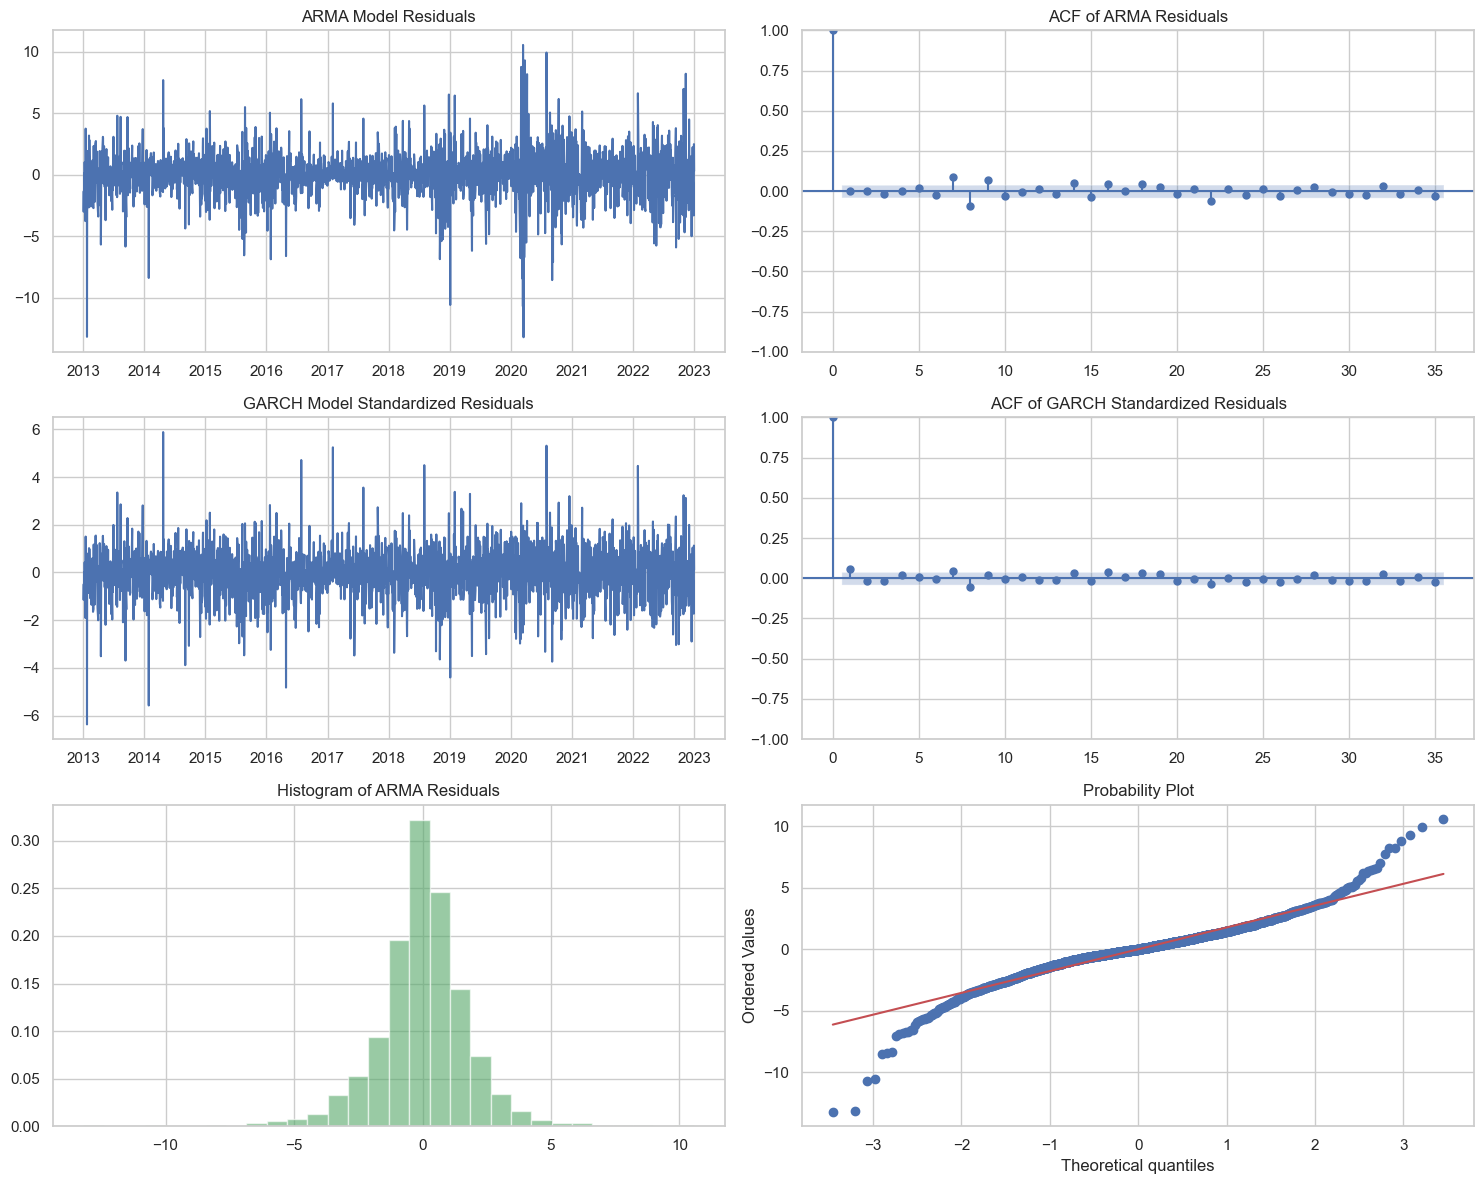

In [76]:
plot_diagnostics(auto_arma_model, residuals, auto_garch_model.resid / auto_garch_model.conditional_volatility)

ARMA Model Residuals: The plot shows residuals from an ARMA model over time. The residuals seem to have variance clustering (periods of high volatility followed by low volatility), which is typical in financial time series and suggests a potential need for a volatility modeling approach like GARCH.

ACF of ARMA Residuals: The Autocorrelation Function (ACF) plot for the ARMA model residuals shows that autocorrelations are within the confidence band (which usually represents a 95% confidence interval), suggesting that the ARMA model has captured the linear dependencies in the data well.

GARCH Model Standardized Residuals: This plot displays the standardized residuals from a GARCH model, which aims to account for changing variance (volatility clustering) in the time series. The residuals do not show any distinct patterns over time, which is a good sign that the GARCH model is performing adequately.

ACF of GARCH Standardized Residuals: The ACF plot for the GARCH standardized residuals also shows that most autocorrelations are within the confidence band, indicating that the GARCH model has successfully captured the autocorrelation in the volatility of the series.

Histogram of ARMA Residuals: The histogram of the ARMA model residuals appears to be roughly symmetrical about zero, suggesting that the residuals might be normally distributed, which is an assumption of the ARMA model.

Probability Plot: The Q-Q (quantile-quantile) plot compares the distribution of the standardized residuals with a normal distribution. The points deviate from the red line (which represents the theoretical quantiles of a normal distribution) in the tails, indicating that the residuals have heavier tails than the normal distribution. This is common in financial time series, where extreme movements are more frequent than what a normal distribution would predict.

In [77]:
# Function for visualizations
def plot_data(original_data, transformed_data, residuals):
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 6))

    plt.subplot(3, 1, 1)
    plt.plot(original_data, label='Original Data')
    plt.title('Original Stock Prices')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(transformed_data, label='Stationary Data')
    plt.title('Transformed Stationary Data')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(residuals, label='Residuals')
    plt.title('Residuals from ARMA Model')
    plt.legend()

    plt.tight_layout()
    plt.show()

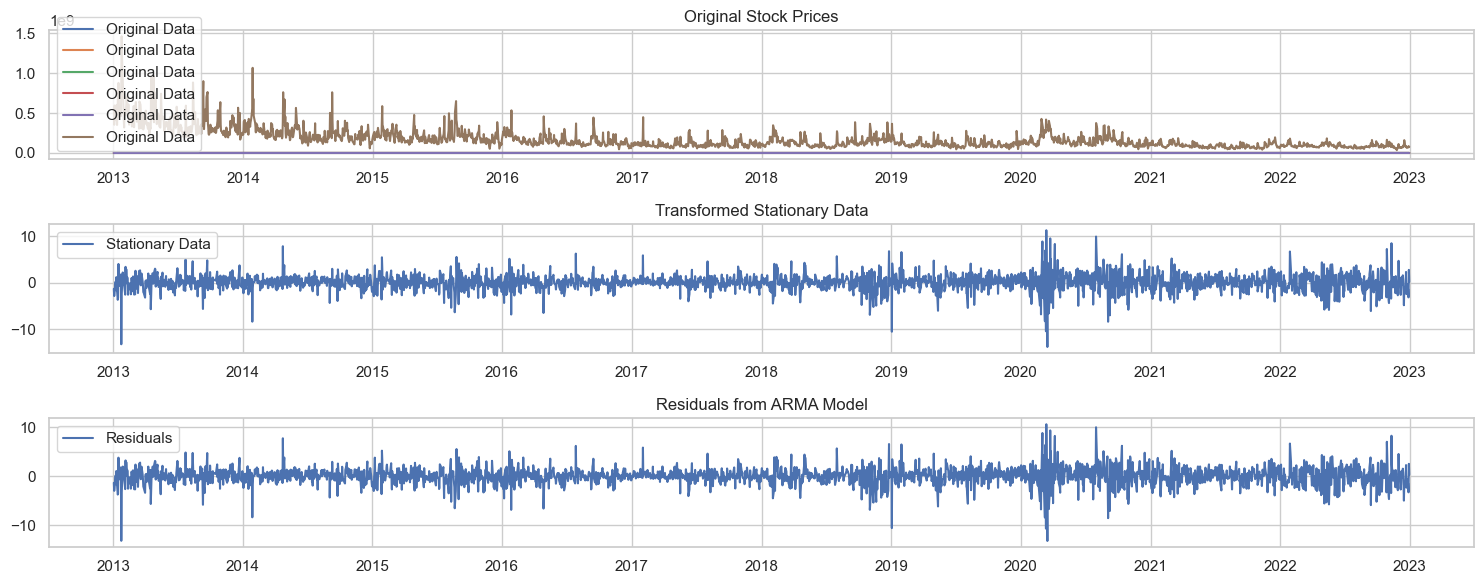

In [78]:
# Visualize the data
plot_data(stock_data, transformed_data, residuals)

In [79]:
transformed_data

Date
2013-01-03   -1.270273
2013-01-04   -2.825003
2013-01-07   -0.589966
2013-01-08    0.268775
2013-01-09   -1.575223
                ...   
2022-12-23   -0.280201
2022-12-27   -1.397553
2022-12-28   -3.116586
2022-12-29    2.793062
2022-12-30    0.246591
Name: Adj Close, Length: 2517, dtype: float64

In [80]:
residuals

Date
2013-01-03   -1.351420
2013-01-04   -2.989974
2013-01-07   -0.857289
2013-01-08    0.134247
2013-01-09   -1.648011
                ...   
2022-12-23   -0.507467
2022-12-27   -1.510299
2022-12-28   -3.291775
2022-12-29    2.506944
2022-12-30    0.321545
Name: None, Length: 2517, dtype: float64

### Data Normalization 

In [81]:
# Function to normalize data
def normalize_data(data):
    scaler = MinMaxScaler()
    # Convert the Series to a NumPy array before reshaping
    data_array = data.values.reshape(-1, 1)
    data_scaled = scaler.fit_transform(data_array)
    return data_scaled, scaler


In [82]:
# Normalize residuals
residuals_normalized, scaler = normalize_data(residuals)

In [83]:
residuals_normalized

array([[0.4983453 ],
       [0.42939236],
       [0.51913913],
       ...,
       [0.4166921 ],
       [0.66071135],
       [0.56874634]])

### Dataset Splitting

In [84]:
# Function to split dataset
def split_dataset(data):
    train, test = train_test_split(data, test_size=0.3, shuffle=False)
    return train, test


# Split the dataset (using residuals)
train_residuals, test_residuals = split_dataset(residuals_normalized)


## Model Implementation

In [85]:
# Function to create sequences and corresponding targets
def create_sequences(data, time_steps=1):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps)])
        ys.append(data[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 5  # Using 5 past days to predict the next day
X_train, y_train = create_sequences(train_residuals, time_steps)
#X_valid, y_valid = create_sequences(validation_residuals, time_steps)
X_test, y_test = create_sequences(test_residuals, time_steps)

In [86]:
# Function to build a model
def build_model(model_type='RNN'):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'GRU':
        model.add(GRU(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
    return model

# Build models
rnn_model = build_model('RNN')
lstm_model = build_model('LSTM')
gru_model = build_model('GRU')

## Model Training

In [87]:
# Train the models
rnn_history = rnn_model.fit(X_train, y_train, epochs=30, validation_split=0.1, verbose=1)

Epoch 1/30
50/50 [==============================] - 2s 17ms/step - loss: 0.0530 - val_loss: 0.0050
Epoch 2/30
50/50 [==============================] - 0s 9ms/step - loss: 0.0053 - val_loss: 0.0048
Epoch 3/30
50/50 [==============================] - 1s 10ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 4/30
50/50 [==============================] - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 5/30
50/50 [==============================] - 0s 9ms/step - loss: 0.0049 - val_loss: 0.0048
Epoch 6/30
50/50 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 7/30
50/50 [==============================] - 1s 11ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 8/30
50/50 [==============================] - 1s 10ms/step - loss: 0.0049 - val_loss: 0.0046
Epoch 9/30
50/50 [==============================] - 0s 10ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 10/30
50/50 [==============================] - 1s 10ms/step - loss: 0.0048 - val_loss: 0.0046
Epoch 11/30


In [88]:
lstm_history = lstm_model.fit(X_train, y_train, epochs=30, validation_split=0.1, verbose=1)

Epoch 1/30
50/50 [==============================] - 4s 20ms/step - loss: 0.0607 - val_loss: 0.0057
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 3/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 5/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 6/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 7/30
50/50 [==============================] - 0s 6ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 8/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 9/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 10/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0044
Epoch 11/30
50/50 

In [89]:
gru_history = gru_model.fit(X_train, y_train, epochs=30, validation_split=0.1, verbose=1)

Epoch 1/30
50/50 [==============================] - 3s 17ms/step - loss: 0.0388 - val_loss: 0.0050
Epoch 2/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 3/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 4/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 5/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 6/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 7/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 8/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 9/30
50/50 [==============================] - 0s 7ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 10/30
50/50 [==============================] - 0s 8ms/step - loss: 0.0047 - val_loss: 0.0045
Epoch 11/30
50/50 

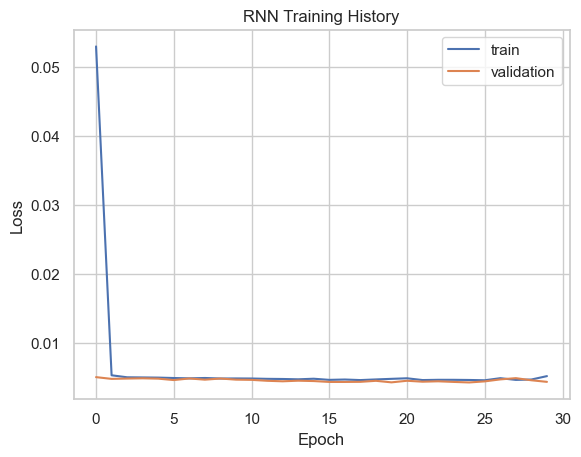

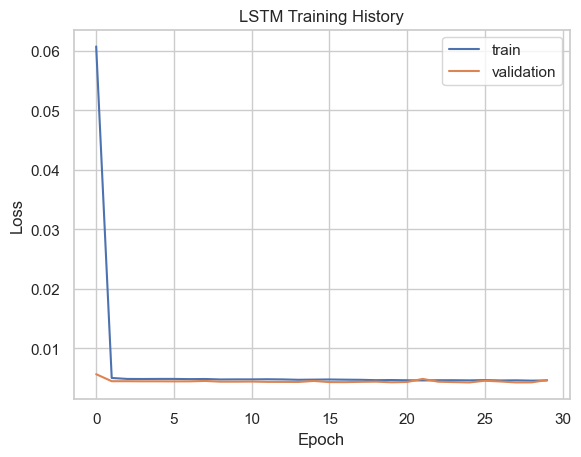

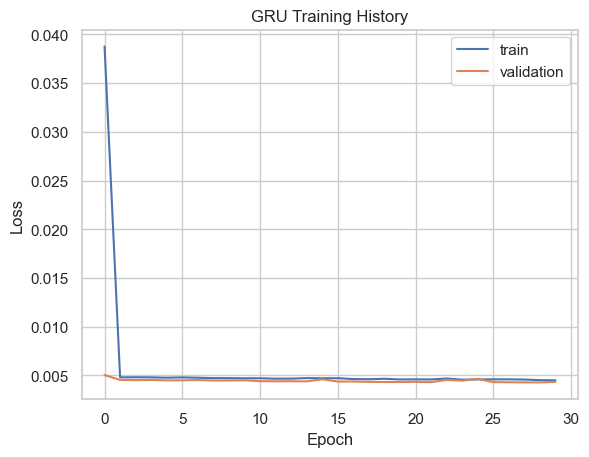

In [90]:
# Function to plot training history
def plot_training_history(history, title):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

# Plot the training histories
plot_training_history(rnn_history, 'RNN Training History')
plot_training_history(lstm_history, 'LSTM Training History')
plot_training_history(gru_history, 'GRU Training History')


## Model Evaluation

In [91]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Function to evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    return mse, mae


In [92]:
# Evaluate the models
mse, mae = evaluate_model(rnn_model,X_test, y_test)

print(f'RNN Test MSE: {mse}, Test MAE: {mae}')

RNN Test MSE: 0.010124371673311594, Test MAE: 0.07235396658061849


In [93]:
mse, mae = evaluate_model(lstm_model,X_test, y_test)

print(f'LSTM Test MSE: {mse}, Test MAE: {mae}')

LSTM Test MSE: 0.009917042006148385, Test MAE: 0.07196541906582958


In [94]:
# Evaluate the models
mse, mae = evaluate_model(gru_model,X_test, y_test)

print(f'GRU Test MSE: {mse}, Test MAE: {mae}')

GRU Test MSE: 0.009921397502499388, Test MAE: 0.07199273475824103


## Experimentation

In [95]:
# Function to build a model with specified hyperparameters
def build_model(model_type, units=50, learning_rate=0.001):
    model = Sequential()
    if model_type == 'RNN':
        model.add(SimpleRNN(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'LSTM':
        model.add(LSTM(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    elif model_type == 'GRU':
        model.add(GRU(units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [96]:
# Function to run an experiment
def run_experiment(model_type, units, learning_rate, batch_size, epochs, X_train, y_train, X_test, y_test):
    # Build the model with the specified hyperparameters
    model = build_model(model_type, units, learning_rate)
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        verbose=0
    )
    
    # Evaluate the model
    mse, mae = evaluate_model(model, X_test, y_test)
    
    # Return the performance metrics and the training history
    return mse, mae, history

### Best LSTM Model Configuration

In [97]:
# Define ranges for hyperparameters
model_types = ['LSTM']
units_range = [50, 100, 150]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [32, 64]
epochs = 50

# Define a dictionary to keep track of the best model and its performance
best_model = {
    'model_type': None,
    'units': None,
    'learning_rate': None,
    'batch_size': None,
    'mse': float('inf'),  # Initialize with an "infinity" value
    'mae': float('inf')
}

# Create a product of all hyperparameter combinations
all_combinations = list(itertools.product(model_types, units_range, learning_rates, batch_sizes))
total_experiments = len(all_combinations)

# Initialize progress bar
progress_bar = tqdm(total=total_experiments, desc='Overall Progress')

# Loop over all possible combinations
for combination in all_combinations:
    model_type, units, learning_rate, batch_size = combination
    
    # Run experiment
    mse, mae, _ = run_experiment(
        model_type=model_type,
        units=units,
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )
    
    # Update progress bar
    progress_bar.update(1)
    progress_bar.set_postfix({
        'Model': model_type,
        'Units': units,
        'LR': learning_rate,
        'Batch': batch_size,
        'MSE': mse,
        'MAE': mae
    })
    
    # Update best model if current model performs better
    if mse < best_model['mse']:
        best_model.update({
            'model_type': model_type,
            'units': units,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'mse': mse,
            'mae': mae
        })

# Close progress bar
progress_bar.close()

# After all experiments, print the best model details
print("Best Model Configuration:")
print(f"Model Type: {best_model['model_type']}")
print(f"Units: {best_model['units']}")
print(f"Learning Rate: {best_model['learning_rate']}")
print(f"Batch Size: {best_model['batch_size']}")
print(f"Test MSE: {best_model['mse']}")
print(f"Test MAE: {best_model['mae']}")


Overall Progress:  17%|▏| 4/24 [03:26<17:12, 51.61s/it, Model=LSTM, Units=50, LR=0.001, Batch=64, MSE=0.00986, MAE=0.07

Overall Progress:   4%|██▋                                                              | 1/24 [00:20<07:55, 20.67s/it]
Overall Progress:   4%| | 1/24 [00:20<07:55, 20.67s/it, Model=LSTM, Units=50, LR=0.0001, Batch=32, MSE=0.01, MAE=0.0726
Overall Progress:   8%| | 2/24 [00:33<05:55, 16.17s/it, Model=LSTM, Units=50, LR=0.0001, Batch=32, MSE=0.01, MAE=0.0726
Overall Progress:   8%| | 2/24 [00:33<05:55, 16.17s/it, Model=LSTM, Units=50, LR=0.0001, Batch=64, MSE=0.0102, MAE=0.07
Overall Progress:  12%|▏| 3/24 [00:55<06:31, 18.62s/it, Model=LSTM, Units=50, LR=0.0001, Batch=64, MSE=0.0102, MAE=0.07
Overall Progress:  12%|▏| 3/24 [00:55<06:31, 18.62s/it, Model=LSTM, Units=50, LR=0.001, Batch=32, MSE=0.00967, MAE=0.07
Overall Progress:  17%|▏| 4/24 [01:08<05:33, 16.65s/it, Model=LSTM, Units=50, LR=0.001, Batch=32, MSE=0.00967, MAE=0.07
Overall Progress:  17%|▏| 4/24 [01:08<

Best Model Configuration:
Model Type: LSTM
Units: 150
Learning Rate: 0.001
Batch Size: 32
Test MSE: 0.009661679630019236
Test MAE: 0.07060750095807097


### Best GRU Model Configuration

In [47]:
# Define ranges for hyperparameters
model_types = ['GRU']
units_range = [50, 100, 150]
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [32, 64]
epochs = 50

# Define a dictionary to keep track of the best model and its performance
best_model = {
    'model_type': None,
    'units': None,
    'learning_rate': None,
    'batch_size': None,
    'mse': float('inf'),  # Initialize with an "infinity" value
    'mae': float('inf')
}

# Create a product of all hyperparameter combinations
all_combinations = list(itertools.product(model_types, units_range, learning_rates, batch_sizes))
total_experiments = len(all_combinations)

# Initialize progress bar
progress_bar = tqdm(total=total_experiments, desc='Overall Progress')

# Loop over all possible combinations
for combination in all_combinations:
    model_type, units, learning_rate, batch_size = combination
    
    # Run experiment
    mse, mae, _ = run_experiment(
        model_type=model_type,
        units=units,
        learning_rate=learning_rate,
        batch_size=batch_size,
        epochs=epochs,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )
    
    # Update progress bar
    progress_bar.update(1)
    progress_bar.set_postfix({
        'Model': model_type,
        'Units': units,
        'LR': learning_rate,
        'Batch': batch_size,
        'MSE': mse,
        'MAE': mae
    })
    
    # Update best model if current model performs better
    if mse < best_model['mse']:
        best_model.update({
            'model_type': model_type,
            'units': units,
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'mse': mse,
            'mae': mae
        })

# Close progress bar
progress_bar.close()

# After all experiments, print the best model details
print("Best Model Configuration:")
print(f"Model Type: {best_model['model_type']}")
print(f"Units: {best_model['units']}")
print(f"Learning Rate: {best_model['learning_rate']}")
print(f"Batch Size: {best_model['batch_size']}")
print(f"Test MSE: {best_model['mse']}")
print(f"Test MAE: {best_model['mae']}")

Overall Progress: 100%|█| 24/24 [06:12<00:00, 15.53s/it, Model=GRU, Units=150, LR=0.1, Batch=64, MSE=0.0111, MAE=0.0781

Best Model Configuration:
Model Type: GRU
Units: 50
Learning Rate: 0.001
Batch Size: 64
Test MSE: 0.009662671760210132
Test MAE: 0.07078901375256343


### Experimenting with different Time Frames on the Best Model

In [98]:
# Function to create sequences and corresponding targets
def create_sequences(data, time_steps):
    Xs, ys = [], []
    for i in range(len(data) - time_steps):
        Xs.append(data[i:(i + time_steps)])
        ys.append(data[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the best model configuration
best_model_config = {
    'model_type': 'LSTM',
    'units': 100,
    'learning_rate': 0.001,
    'batch_size': 32,
    'epochs': 50  # Assuming you want to keep the epochs the same as before
}

# Experiment with different time frames
time_frames = {
    'short_term': 3,
    'medium_term': 5,
    'long_term': 10
}

# Directory where the best model will be saved
model_save_dir = 'best_model'
os.makedirs(model_save_dir, exist_ok=True)  # Create directory if it doesn't exist

# Keep track of the best time frame and model
best_time_frame = None
best_mse = float('inf')
best_mae = float('inf')
best_model = None

for term, steps in time_frames.items():
    # Create sequences for the given time frame
    X_train, y_train = create_sequences(train_residuals, steps)
    X_test, y_test = create_sequences(test_residuals, steps)

    # Build and compile the LSTM model
    model = Sequential()
    model.add(LSTM(best_model_config['units'], input_shape=(steps, 1)))  # Assuming 1 feature in the data
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=best_model_config['learning_rate']), loss='mean_squared_error')
    
    # Train the LSTM model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)
    model.fit(X_train, y_train, epochs=best_model_config['epochs'], batch_size=best_model_config['batch_size'],
              verbose=0, validation_split=0.1)

    # Evaluate the model
    mse, mae = evaluate_model(model, X_test, y_test)
    print(f'{term} term - Time Steps: {steps}')
    print(f'Test MSE: {mse}, Test MAE: {mae}\n')

    # Update the best time frame and model
    if mse < best_mse:
        best_mse = mse
        best_mae = mae
        best_time_frame = term
        best_model = model
        # Save the best model
        best_model.save(os.path.join(model_save_dir, f'best_model_{term}.h5'))

# Print the best time frame and its performance
print(f'Best Time Frame: {best_time_frame}')
print(f'Best Test MSE: {best_mse}')
print(f'Best Test MAE: {best_mae}')


short_term term - Time Steps: 3
Test MSE: 0.009649876921572353, Test MAE: 0.07061959721633712

medium_term term - Time Steps: 5
Test MSE: 0.010150694432266629, Test MAE: 0.07325915087812152

long_term term - Time Steps: 10
Test MSE: 0.009866507453375873, Test MAE: 0.07171325395124244

Best Time Frame: short_term
Best Test MSE: 0.009649876921572353
Best Test MAE: 0.07061959721633712


## Predictions on Residuals

In [99]:
# Generate Predictions on Test Residuals
def generate_predictions(model, data, time_frame):
    predictions = []
    for i in range(time_frame, len(data)):
        input_seq = data[i - time_frame:i].reshape(1, time_frame, 1)
        predicted = model.predict(input_seq)[0, 0]
        predictions.append(predicted)
    return np.array(predictions)

best_time_frame = 3
predicted_residuals = generate_predictions(best_model, test_residuals, best_time_frame)


In [100]:
predicted_residuals

array([0.564131  , 0.5617537 , 0.56653017, 0.56969106, 0.56541383,
       0.5689118 , 0.5608218 , 0.5603425 , 0.5652269 , 0.56658953,
       0.56188   , 0.56299317, 0.5640001 , 0.56217825, 0.5539872 ,
       0.56717974, 0.57026315, 0.5645717 , 0.5501732 , 0.55718553,
       0.5702898 , 0.5677068 , 0.5670675 , 0.55999947, 0.5626519 ,
       0.5609828 , 0.5684011 , 0.56263965, 0.56226736, 0.5572398 ,
       0.56460613, 0.5606368 , 0.55534685, 0.546429  , 0.5475119 ,
       0.5624794 , 0.54444844, 0.5558043 , 0.5856077 , 0.56201005,
       0.57350624, 0.5572122 , 0.5563487 , 0.53748995, 0.57328695,
       0.55778706, 0.5311806 , 0.5829196 , 0.5330503 , 0.56264806,
       0.5573255 , 0.55856353, 0.54295564, 0.5497126 , 0.5854597 ,
       0.5695129 , 0.5778102 , 0.55576164, 0.567061  , 0.56385744,
       0.5477606 , 0.56167924, 0.5590159 , 0.5842091 , 0.56696576,
       0.5699067 , 0.56674445, 0.56897664, 0.5779821 , 0.5650728 ,
       0.5647323 , 0.55932224, 0.55543256, 0.55138147, 0.56680

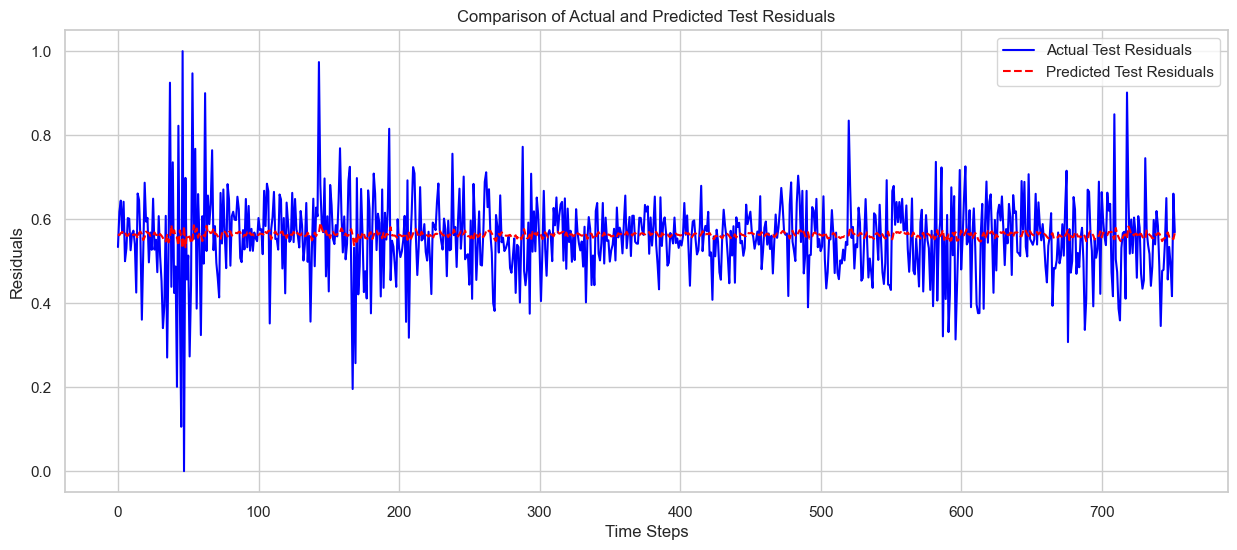

In [101]:
# Plotting the actual test residuals
plt.figure(figsize=(15, 6))
plt.plot(test_residuals[best_time_frame:], label='Actual Test Residuals', color='blue')

# Plotting the predicted residuals
plt.plot(predicted_residuals, label='Predicted Test Residuals', color='red', linestyle='dashed')

plt.title('Comparison of Actual and Predicted Test Residuals')
plt.xlabel('Time Steps')
plt.ylabel('Residuals')
plt.legend()
plt.show()

## Post-Processing Forecasts

### Forecasting the Next 10 Residuals

In [102]:
def forecast_next_n_resid(model, latest_data, time_steps, n_forecasts):
    forecasted_resid = []
    current_batch = latest_data[-time_steps:].reshape(1, time_steps, 1)

    for i in range(n_forecasts):
        # Get prediction 1 time step ahead
        current_pred = model.predict(current_batch)[0]
        # Store the prediction
        forecasted_resid.append(current_pred)
        # Update batch to include prediction and drop first value
        current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

    return np.array(forecasted_resid)

n_forecasts = 10
predicted_resid = forecast_next_n_resid(best_model, latest_data, best_time_frame, n_forecasts)

In [103]:
predicted_resid

array([[0.56521267],
       [0.56401944],
       [0.56357574],
       [0.56351256],
       [0.5634962 ],
       [0.5634925 ],
       [0.5634917 ],
       [0.5634916 ],
       [0.5634916 ],
       [0.5634915 ]], dtype=float32)

### Reversing Normalization

In [104]:
predicted_resid_normalized = scaler.inverse_transform(predicted_resid)


In [105]:
predicted_resid_normalized

array([[0.2375736 ],
       [0.20921855],
       [0.19867481],
       [0.19717342],
       [0.1967839 ],
       [0.19669609],
       [0.19667767],
       [0.19667484],
       [0.19667484],
       [0.19667342]], dtype=float32)

### Forecasting the Next 10 Values

In [111]:
def forecast_next_values(model, latest_data, time_steps, future_steps):
    future_predictions = []
    input_sequence = latest_data[-time_steps:].reshape(1, time_steps, 1)

    for _ in range(future_steps):
        # Predict the next value
        next_value = model.predict(input_sequence)[0, 0]
        future_predictions.append(next_value)
        
        # Update the input sequence to include the predicted value
        input_sequence = np.roll(input_sequence, -1)
        input_sequence[0, -1, 0] = next_value

    return np.array(future_predictions)

# Forecast the next 10 residuals
future_steps = 10
predicted_residuals = forecast_next_values(best_model, test_residuals, best_time_frame, future_steps)


### Reverse Transformations

In [112]:
# Assuming normalization was applied
def reverse_normalization(normalized_values, scaler):
    return scaler.inverse_transform(normalized_values.reshape(-1, 1)).reshape(-1)

normalization_applied = True
# Reverse normalization if applied
if normalization_applied:
    predicted_residuals = reverse_normalization(predicted_residuals, scaler)

# Reverse differencing and logarithmic transformation
def reverse_transform(residuals, last_log_value):
    reversed_values = [last_log_value + val / 100 for val in residuals]
    return np.exp(reversed_values)

last_log_value = np.log(stock_data['Adj Close'].iloc[-1])
forecasted_prices = reverse_transform(predicted_residuals, last_log_value)


In [108]:
forecasted_prices

array([129.51512271, 129.47840384, 129.4647527 , 129.46280894,
       129.46230466, 129.46219098, 129.46216713, 129.46216347,
       129.46216347, 129.46216164])

### Visualization

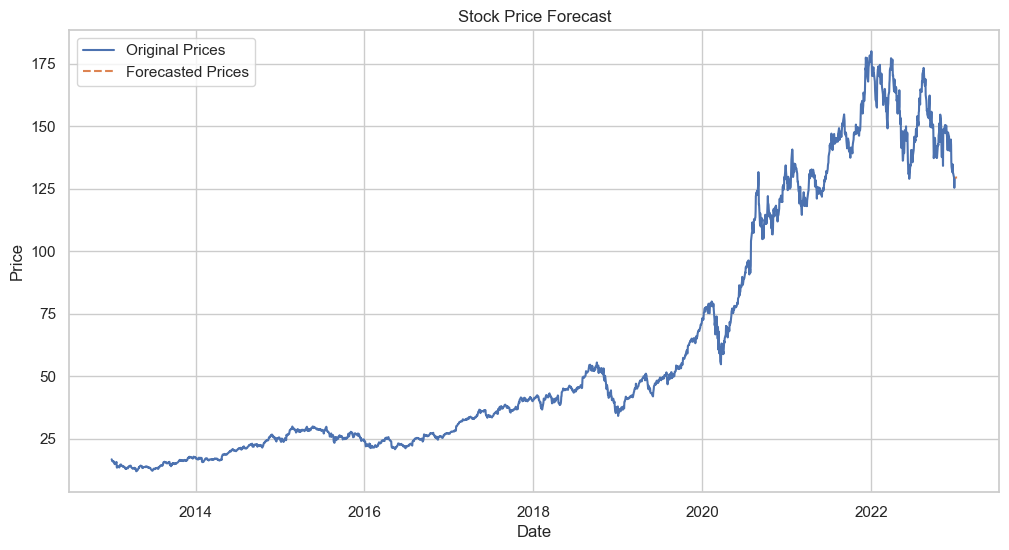

In [109]:
# Extract the dates for plotting
forecast_dates = pd.date_range(start=stock_data.index[-1], periods=future_steps + 1)[1:]

# Plot original and forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Adj Close'], label='Original Prices')
plt.plot(forecast_dates, forecasted_prices, label='Forecasted Prices', linestyle='--')
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


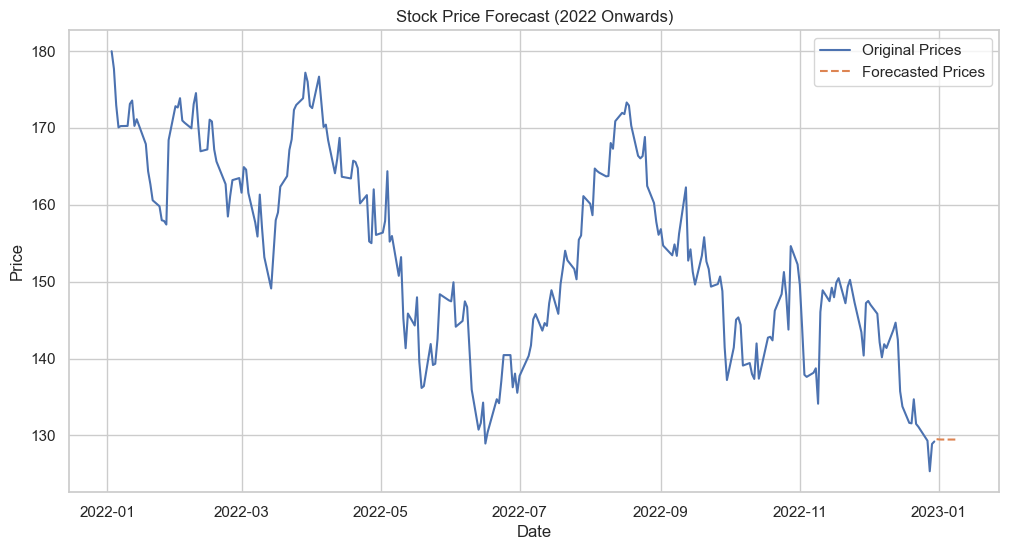

In [110]:
# Filter the data to show only 2022 onwards
stock_data_filtered = stock_data[stock_data.index.year >= 2022]

# Extract the dates for plotting the forecasts
forecast_dates = pd.date_range(start=stock_data_filtered.index[-1], periods=future_steps + 1)[1:]

# Plot original and forecasted prices
plt.figure(figsize=(12, 6))
plt.plot(stock_data_filtered['Adj Close'], label='Original Prices')
plt.plot(forecast_dates, forecasted_prices, label='Forecasted Prices', linestyle='--')
plt.title('Stock Price Forecast (2022 Onwards)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()